xkcd 1313: Regex Golf (Part 2: Infinite Problems)
====

<p style="text-align: right"><i>Peter Norvig<br>with Stefan Pochmann<br>Feb 2014<br>revised Nov 2015</i></p>



<a href="http://xkcd.com/1313"><img src="http://imgs.xkcd.com/comics/regex_golf.png"></a>

This Again?
----

Last month I demonstrated [a simple Regex Golf program](http://nbviewer.ipython.org/url/norvig.com/ipython/xkcd1313.ipynb?create=1). I thought that was the end of the topic, but [Stefan Pochmann](http://www.stefan-pochmann.info/spocc/) sent me a series of emails suggesting some impressive improvements. ([Davide Canton](https://plus.sandbox.google.com/108324296451294887432/posts) and [Thomas Breuel](https://plus.google.com/118190679520611168174/posts) also had good suggestions.) So this post is an exploration of some of Stefan's new ideas, and some of my own. It's a story about regex golf, and about using exploratory programming to test out ideas.

To review, here's the program from [part 1](http://nbviewer.ipython.org/url/norvig.com/ipython/xkcd1313.ipynb?create=1), with some minor modifications:

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from __future__ import division, print_function

In [2]:
from collections import Counter, defaultdict
import re
import itertools
import random 

Set = frozenset # Data will be frozensets, so they can't be mutated.

def words(text):
    "All space-separated words in text."
    return Set(text.split())

def phrases(text, sep='/'): 
    "All sep-separated phrases in text, uppercased and stripped."
    return Set(p.upper().strip() for p in text.split(sep))

def mistakes(regex, winners, losers):
    "The set of mistakes made by this regex in classifying winners and losers."
    return ({"Should have matched: " + W 
             for W in winners if not re.search(regex, W)} |
            {"Should not have matched: " + L 
             for L in losers if re.search(regex, L)})

def findregex(winners, losers, k=4):
    "Find a regex that matches all winners but no losers (sets of strings)."
    # Make a pool of regex parts, then pick from them to cover winners.
    # On each iteration, add the 'best' part to 'solution',
    # remove winners covered by best, and keep in 'pool' only parts
    # that still match some winner.
    pool = regex_parts(winners, losers)
    solution = []
    def score(p): return k * len(matches(p, winners)) - len(p)
    while winners:
        best = max(pool, key=score)
        solution.append(best)
        winners = winners - matches(best, winners)
        pool = {p for p in pool if matches(p, winners)}
    return OR(solution)

def matches(regex, strings):
    "Return a set of all the strings that are matched by regex."
    return {s for s in strings if re.search(regex, s)}

OR  = '|'.join # Join a sequence of strings with '|' between them
cat = ''.join  # Join a sequence of strings with nothing between them

def regex_parts(winners, losers):
    "Return parts that match at least one winner, but no loser."
    wholes = {'^' + w + '$' for w in winners}
    parts = {d for w in wholes for p in subparts(w) for d in dotify(p)}
    return wholes | {p for p in parts if not matches(p, losers)}

def subparts(word):
    "Return a set of subparts of word: consecutive characters up to length 4."
    return set(word[i:i+n] for i in range(len(word)) for n in (1, 2, 3, 4)) 
    
def dotify(part):
    "Return all ways to replace a subset of chars in part with '.'."
    choices = map(replacements, part)
    return {cat(chars) for chars in itertools.product(*choices)}

def replacements(c): 
    "All ways to replace character c with something interesting: for now, 'c' or '.'."
    return c if c in '^$' else c + '.'

def report(winners, losers):
    "Find a regex to match A but not B, and vice-versa.  Print summary."
    solution = findregex(winners, losers)
    assert not mistakes(solution, winners, losers)
    print('Chars: {}, ratio: {:.1f}, inputs: {}:{}'.format(
          len(solution), len(trivial(winners)) / len(solution) , len(winners), len(losers)))
    return solution

def trivial(winners): return '^(' + OR(winners) + ')$'

Here are some "arbitrary lists" (see panel two of the comic) which we will be using to test out the code. 

In [3]:
winners = words('''washington adams jefferson jefferson madison madison monroe 
    monroe adams jackson jackson van-buren harrison polk taylor pierce buchanan 
    lincoln lincoln grant grant hayes garfield cleveland harrison cleveland mckinley
    mckinley roosevelt taft wilson wilson harding coolidge hoover roosevelt 
    roosevelt roosevelt roosevelt truman eisenhower eisenhower kennedy johnson nixon 
    nixon carter reagan reagan bush clinton clinton bush bush obama obama''')
losers = words('''clinton jefferson adams pinckney pinckney clinton king adams 
    jackson adams clay van-buren van-buren clay cass scott fremont breckinridge 
    mcclellan seymour greeley tilden hancock blaine cleveland harrison bryan bryan 
    parker bryan roosevelt hughes cox davis smith hoover landon wilkie dewey dewey 
    stevenson stevenson nixon goldwater humphrey mcgovern ford carter mondale 
    dukakis bush dole gore kerry mccain romney''') - winners

boys = words('jacob mason ethan noah william liam jayden michael alexander aiden')
girls = words('sophia emma isabella olivia ava emily abigail mia madison elizabeth')

pharma = words('lipitor nexium plavix advair ablify seroquel singulair crestor actos epogen')
cities = words('paris trinidad capetown riga zurich shanghai vancouver chicago adelaide auckland')

foo = words('''afoot catfoot dogfoot fanfoot foody foolery foolish fooster footage foothot footle footpad footway 
    hotfoot jawfoot mafoo nonfood padfoot prefool sfoot unfool''')
bar = words('''Atlas Aymoro Iberic Mahran Ormazd Silipan altared chandoo crenel crooked fardo folksy forest 
    hebamic idgah manlike marly palazzi sixfold tarrock unfold''')

nouns = words('''time year people way day man thing woman life child world school 
    state family student group country problem hand part place case week company 
    system program question work government number night point home water room 
    mother area money story fact month lot right study book eye job word business 
    issue side kind head house service friend father power hour game line end member 
    law car city community name president team minute idea kid body information 
    back parent face others level office door health person art war history party result 
    change morning reason research girl guy moment air teacher force education''')
adverbs = words('''all particularly just less indeed over soon course still yet before 
    certainly how actually better to finally pretty then around very early nearly now 
    always either where right often hard back home best out even away enough probably 
    ever recently never however here quite alone both about ok ahead of usually already 
    suddenly down simply long directly little fast there only least quickly much forward 
    today more on exactly else up sometimes eventually almost thus tonight as in close 
    clearly again no perhaps that when also instead really most why ago off 
    especially maybe later well together rather so far once''') - nouns  
verbs = words('''ask believe borrow break bring buy can be able cancel change clean
    comb complain cough count cut dance draw drink drive eat explain fall
    fill find finish fit fix fly forget give go have hear hurt know learn
    leave listen live look lose make do need open close shut organise pay
    play put rain read reply run say see sell send sign sing sit sleep
    smoke speak spell spend stand start begin study succeed swim take talk
    teach tell think translate travel try turn off turn on type understand
    use wait wake up want watch work worry write''') - nouns

randoms = Set(vars(random))
builtins = Set(vars(__builtin__)) - randoms

starwars = phrases('''The Phantom Menace / Attack of the Clones / Revenge of the Sith /
    A New Hope / The Empire Strikes Back / Return of the Jedi''')
startrek = phrases('''The Wrath of Khan / The Search for Spock / The Voyage Home /
    The Final Frontier / The Undiscovered Country / Generations / First Contact /
    Insurrection / Nemesis''')

dogs = phrases(''''Labrador Retrievers / German Shepherd Dogs / Golden Retrievers / Beagles / Bulldogs / 
    Yorkshire Terriers / Boxers / Poodles / Rottweilers / Dachshunds / Shih Tzu / Doberman Pinschers / 
    Miniature Schnauzers / French Bulldogs / German Shorthaired Pointers / Siberian Huskies / Great Danes / 
    Chihuahuas / Pomeranians / Cavalier King Charles Spaniels / Shetland Sheepdogs / Australian Shepherds / 
    Boston Terriers / Pembroke Welsh Corgis / Maltese / Mastiffs / Cocker Spaniels / Havanese / 
    English Springer Spaniels / Pugs / Brittanys / Weimaraners / Bernese Mountain Dogs / Vizslas / Collies / 
    West Highland White Terriers / Papillons / Bichons Frises / Bullmastiffs / Basset Hounds / 
    Rhodesian Ridgebacks / Newfoundlands / Russell Terriers / Border Collies / Akitas / 
    Chesapeake Bay Retrievers / Miniature Pinschers / Bloodhounds / St. Bernards / Shiba Inu / Bull Terriers / 
    Chinese Shar-Pei / Soft Coated Wheaten Terriers / Airedale Terriers / Portuguese Water Dogs / Whippets / 
    Alaskan Malamutes / Scottish Terriers / Australian Cattle Dogs / Cane Corso / Lhasa Apsos / 
    Chinese Crested / Cairn Terriers / English Cocker Spaniels / Dalmatians / Italian Greyhounds / 
    Dogues de Bordeaux / Samoyeds / Chow Chows / German Wirehaired Pointers / Belgian Malinois / 
    Great Pyrenees / Pekingese / Irish Setters / Cardigan Welsh Corgis / Staffordshire Bull Terriers / 
    Irish Wolfhounds / Old English Sheepdogs / American Staffordshire Terriers / Bouviers des Flandres / 
    Greater Swiss Mountain Dogs / Japanese Chin / Tibetan Terriers / Brussels Griffons / 
    Wirehaired Pointing Griffons / Border Terriers / English Setters / Basenjis / Standard Schnauzers / 
    Silky Terriers / Flat-Coated Retrievers / Norwich Terriers / Afghan Hounds / Giant Schnauzers / Borzois / 
    Wire Fox Terriers / Parson Russell Terriers / Schipperkes / Gordon Setters / Treeing Walker Coonhounds''')
cats = phrases('''Abyssinian / Aegean cat / Australian Mist / American Curl / American Bobtail / 
    American Polydactyl / American Shorthair / American Wirehair / Arabian Mau / Asian / Asian Semi-longhair / 
    Balinese / Bambino / Bengal / Birman / Bombay / Brazilian Shorthair / British Shorthair / British Longhair / 
    Burmese / Burmilla / California Spangled Cat / Chantilly/Tiffany / Chartreux / Chausie / Cheetoh / 
    Colorpoint Shorthair / Cornish Rex / Cymric / Cyprus cat / Devon Rex / Donskoy or Don Sphynx / Dragon Li / 
    Dwelf / Egyptian Mau / European Shorthair / Exotic Shorthair / German Rex / Havana Brown / Highlander / 
    Himalayan-Colorpoint Persian / Japanese Bobtail / Javanese / Khao Manee / Korat / Korn Ja / 
    Kurilian Bobtail / LaPerm / Maine Coon / Manx / Mekong bobtail / Minskin / Munchkin / Nebelung / Napoleon / 
    Norwegian Forest Cat / Ocicat / Ojos Azules / Oregon Rex / Oriental Bicolor / Oriental Shorthair / 
    Oriental Longhair / Persian / Peterbald / Pixie-bob / Ragamuffin / Ragdoll / Russian Blue / Russian Black / 
    Sam Sawet / Savannah / Scottish Fold / Selkirk Rex / Serengeti cat / Serrade petit / Siamese / Siberian / 
    Singapura / Snowshoe / Sokoke / Somali / Sphynx / Swedish forest cat / Thai / Tonkinese / Toyger / 
    Turkish Angora / Turkish Van / Ukrainian Levkoy / York Chocolate Cat''')

movies = phrases('''Citizen Kane / The Godfather / Vertigo / 2001: A Space Odyssey / The Searchers / Sunrise / 
    Singin’ in the Rain / Psycho / Casablanca / The Godfather Part II / The Magnificent Ambersons / Chinatown / 
    North by Northwest / Nashville / The Best Years of Our Lives / McCabe & Mrs Miller / The Gold Rush / 
    City Lights / Taxi Driver / Goodfellas / Mulholland Drive / Greed / Annie Hall / The Apartment / 
    Do the Right Thing / Killer of Sheep / Barry Lyndon / Pulp Fiction / Raging Bull / Some Like It Hot / 
    A Woman Under the Influence / The Lady Eve / The Conversation / The Wizard of Oz / Double Indemnity / 
    Star Wars / Imitation of Life / Jaws / The Birth of a Nation / Meshes of the Afternoon / Rio Bravo / 
    Dr Strangelove / Letter from an Unknown Woman / Sherlock Jr / The Man Who Shot Liberty Valance / 
    It’s a Wonderful Life / Marnie / A Place in the Sun / Days of Heaven / His Girl Friday / Touch of Evil / 
    The Wild Bunch / Grey Gardens / Sunset Boulevard / The Graduate / Back to the Future / Crimes and Misdemeanors / 
    The Shop Around the Corner / One Flew Over the Cuckoo’s Nest / Blue Velvet / Eyes Wide Shut / The Shining / 
    Love Streams / Johnny Guitar / The Right Stuff / Red River / Modern Times / Notorious / Koyaanisqatsi / 
    The Band Wagon / Groundhog Day / The Shanghai Gesture / Network / Forrest Gump / 
    Close Encounters of the Third Kind / The Empire Strikes Back / Stagecoach / Schindler’s List / 
    The Tree of Life / Meet Me in St Louis / Thelma & Louise / Raiders of the Lost Ark / Bringing Up Baby / 
    Deliverance / Night of the Living Dead / The Lion King / Eternal Sunshine of the Spotless Mind / 
    West Side Story / In a Lonely Place / Apocalypse Now / ET: The Extra-Terrestrial / The Night of the Hunter / 
    Mean Streets / 25th Hour / Duck Soup / The Dark Knight / Gone With the Wind / Heaven’s Gate / 12 Years a Slave / 
    Ace in the Hole''')
tv = phrases('''The Abbott and Costello Show / ABC’s Wide World of Sports / Alfred Hitchcock Presents /
    All in the Family / An American Family / American Idol / Arrested Development / Battlestar Galactica /
    The Beavis and Butt-Head Show / The Bob Newhart Show / Brideshead Revisited / Buffalo Bill /
    Buffy the Vampire Slayer / The Carol Burnett Show / The CBS Evening News with Walter Cronkite /
    A Charlie Brown Christmas / Cheers / The Cosby Show / The Daily Show / Dallas / The Day After / 
    Deadwood / The Dick Van Dyke Show / Dragnet / The Ed Sullivan Show / The Ernie Kovacs Show /
    Felicity / Freaks and Geeks / The French Chef / Friends / General Hospital /
    The George Burns and Gracie Allen Show / Gilmore Girls / Gunsmoke / Hill Street Blues /
    Homicide: Life on the Street / The Honeymooners / I, Claudius / I Love Lucy / King of the Hill /
    The Larry Sanders Show / Late Night with David Letterman / Leave It to Beaver / Lost /
    Married with Children / Mary Hartman, Mary Hartman / The Mary Tyler Moore Show / MASH / The Monkees /
    Monty Python’s Flying Circus / Moonlighting / My So-Called Life / Mystery Science Theater 3000 /
    The Odd Couple / The Office / The Oprah Winfrey Show / Pee Wee’s Playhouse / Playhouse 90 /
    The Price Is Right / Prime Suspect / The Prisoner / The Real World / Rocky and His Friends / Roots /
    Roseanne / Sanford and Son / Saturday Night Live / Second City Television / See It Now / Seinfeld /
    Sesame Street / Sex and the City / The Shield / The Simpsons / The Singing Detective / Six Feet Under /
    60 Minutes / Soap / The Sopranos / South Park / SpongeBob SquarePants / SportsCenter / Star Trek /
    St Elsewhere / The Super Bowl / Survivor / Taxi /The Tonight Show Starring Johnny Carson /
    24 / The Twilight Zone / Twin Peaks / The West Wing / What’s My Line / WKRP in Cincinnati /
    The Wire / Wiseguy / The X-Files''')

stars = phrases('''Humphrey Bogart / Cary Grant / James Stewart / Marlon Brando / Fred Astaire / Henry Fonda / 
    Clark Gable / James Cagney / Spencer Tracy / Charlie Chaplin / Gary Cooper / Gregory Peck / John Wayne / 
    Laurence Olivier / Gene Kelly / Orson Welles / Kirk Douglas / James Dean / Burt Lancaster / Marx Brothers / 
    Buster Keaton / Sidney Poitier / Robert Mitchum / Edward G. Robinson / William Holden / Katharine Hepburn / 
    Bette Davis / Audrey Hepburn / Ingrid Bergman / Greta Garbo / Marilyn Monroe / Elizabeth Taylor / Judy Garland / 
    Marlene Dietrich / Joan Crawford / Barbara Stanwyck / Claudette Colbert / Grace Kelly / Ginger Rogers / 
    Mae West / Vivien Leigh / Lillian Gish / Shirley Temple / Rita Hayworth / Lauren Bacall / Sophia Loren / 
    Jean Harlow / Carole Lombard / Mary Pickford / Ava Gardner''')
scientists = phrases('''Alain Aspect / Martin Karplus / David Baltimore / Donald Knuth / Allen Bard / 
    Robert Marks II / Timothy Berners-Lee / Craig Mello / John Tyler Bonner / Luc Montagnier / Dennis Bray / 
    Gordon Moore / Sydney Brenner / Kary Mullis / Pierre Chambon / C Nüsslein-Volhard / Simon Conway Morris / 
    Seiji Ogawa / Mildred Dresselhaus / Jeremiah Ostriker / Gerald M Edelman / Roger Penrose / Ronald Evans / 
    Stanley Prusiner / Anthony Fauci / Henry F Schaefer III / Anthony Fire / Thomas Südhof / Jean Frechet / 
    Jack Szostak / Margaret Geller / James Tour / Jane Goodall / Charles Townes / Alan Guth / Harold Varmus / 
    Lene Vestergaard Hau / Craig Venter / Stephen Hawking / James Watson / Peter Higgs / Steven Weinberg / 
    Leroy Hood / George Whitesides / Eric Kandel / Edward Wilson / Andrew Knoll / Edward Witten / Charles Kao / 
    Shinya Yamanaka''')

And here we show how it works:

In [4]:
solution = findregex(starwars, startrek)
solution

' T|E.P|OP'

In [5]:
not mistakes(solution, starwars, startrek) 

True

Plan of Attack
----

To improve the program, I'll take the following steps:

- *Profiling:* Figure out where the program spends its time.
- *Speedup:* Make the program faster.
- *Benchmarking:* Run the program over pairs of arbitrary lists to see how fast it is and how short the solutions are. 
- *Analyzing:* Learn something by looking at the benchmark results.
- *Searching:* Introduce a better search algorithm.
- *Eliminating Parts:* Get rid of parts that can't possibly be part of an optimal solution.
- *Adding Parts:* Add new types of parts to allow new, shorter solutions.
- *Randomizing Search:* Randomness allows us to explore different parts of the search space.
- *Speculating:* Think about what we could do next.

Profiling 
----

Let's time how long it takes to separate the top 100 adverbs from top 100 nouns:

In [6]:
%timeit findregex(adverbs, nouns)

1 loops, best of 3: 5.4 s per loop


On my computer it was 4 seconds.  I have some ideas for how to make this faster, but I know that I shouldn't waste effort trying to speed up parts of a program that [don't take much of the total time](http://en.wikipedia.org/wiki/Amdahl's_law).  I'll use the [`cProfile`](http://docs.python.org/2/library/profile.html#module-cProfile) module to see where the time goes:

In [7]:
import cProfile

cProfile.run('findregex(adverbs, nouns)', sort='cumulative')

         12220085 function calls in 7.748 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    7.748    7.748 {built-in method builtins.exec}
        1    0.000    0.000    7.748    7.748 <string>:1(<module>)
        1    0.001    0.001    7.748    7.748 <ipython-input-2-f601ec24f6b0>:23(findregex)
    54424    0.051    0.000    7.652    0.000 <ipython-input-2-f601ec24f6b0>:39(matches)
    54424    1.052    0.000    7.601    0.000 <ipython-input-2-f601ec24f6b0>:41(<setcomp>)
  2841615    1.347    0.000    6.549    0.000 re.py:170(search)
  2841615    1.482    0.000    4.016    0.000 re.py:278(_compile)
       41    0.015    0.000    3.584    0.087 {built-in method builtins.max}
    25445    0.033    0.000    3.569    0.000 <ipython-input-2-f601ec24f6b0>:31(score)
       41    0.021    0.001    3.335    0.081 <ipython-input-2-f601ec24f6b0>:36(<setcomp>)
    45055    0.223    0.000    2.459    0.00

About 99% of the time was spent in `matches`. And most of the time in `matches` goes to `re.search`. So my thoughts are: 
    
+ Can we make each call to `matches` run faster? 
+ Can we make fewer calls to `matches`?
+ Can we use `re.search` more effectively? 
+ Nothing else matters.  99% of the time is in `matches`; don't waste effort speeding up anything else.

# Speedup:  Faster `matches` by Compiling Regexes


The `re` package uses strings to specify regular expressions, but internally, when we call `re.search` on a string, that string is compiled, with the function `re.compile`, into an object that has a `search` method.  If you need to search many times with the same regex, then it is faster to call `re.compile` once, and then call the `search` method of the compiled object, rather than calling `re.search` each time.

Another trick: use the builtin function `filter` rather than a set comprehension. Builtins, written in C, are often faster.

In [8]:
def matches(regex, strings):
    "Return a set of all the strings that are matched by regex."
    searcher = re.compile(regex).search
    return set(filter(searcher, strings))

One thing to be careful about: the `re` module manages a cache of recent compilations. I call `re.purge()` before each timing, to make sure that I'm not re-using any work that was done before the timing started.

In [9]:
re.purge()

%timeit findregex(adverbs, nouns)

1 loops, best of 3: 2.95 s per loop


*That was almost twice as fast!*  Not bad for changing two lines.  

# Speedup: Fewer `matches` Against Losers

In `regex_parts`, for each part, `p`, we test `if not matches(p, losers)`. This applies `searcher` to every loser and builds up a set of all those that match.  It would be faster if we could *exit early*: as soon as we find one loser that matches, we don't need to apply `searcher` to the remaining losers.  Stefan Pochmann came up with a great way to do this. If we concatenate the list of losers together into one big string, then we only need one call to `re.search` for each part `p`.  If a part matches the big string anywhere, the call will return immediately, and we will know the part is no good. 

There is one catch: we have to make sure that the start of each loser matches `'^'` and the end matches `'$'`.  We can do that by concatenating together the losers with a newline between them, and by using the `re.MULTILINE` option. (See the [`re` module documentation](http://docs.python.org/2/library/re.html)  if this is unfamiliar.)

Here is the change, with timing before and after:

In [10]:
re.purge()

%timeit regex_parts(adverbs, nouns)

1 loops, best of 3: 271 ms per loop


In [11]:
def regex_parts(winners, losers):
    "Return parts that match at least one winner, but no loser."
    losers_str = '\n'.join(losers)
    def no_losers(part): return not re.compile(part, re.MULTILINE).search(losers_str)
    wholes = {'^' + w + '$' for w in winners}
    parts = {d for w in wholes for p in subparts(w) for d in dotify(p)}
    return wholes | set(filter(no_losers, parts))

In [12]:
re.purge()

%timeit regex_parts(adverbs, nouns)

10 loops, best of 3: 171 ms per loop


We've made `regex_parts` almost two times faster.

# Speedup: Fewer `matches` Against Winners

Here's what `findregex` currently looks like:

In [13]:
def findregex(winners, losers, k=4):
    "Find a regex that matches all winners but no losers (sets of strings)."
    # Make a pool of regex parts, then pick from them to cover winners.
    # On each iteration, add the 'best' part to 'solution',
    # remove winners covered by best, and keep in 'pool' only parts
    # that still match some winner.
    pool = regex_parts(winners, losers)
    solution = []
    def score(p): return k * len(matches(p, winners)) - len(p)
    while winners:
        best = max(pool, key=score)
        solution.append(best)
        winners = winners - matches(best, winners)
        pool = {p for p in pool if matches(p, winners)}
    return OR(solution)

Notice that we call `matches` twice (once within `score`) for every part in the pool on every iteration of the main loop. If there are 50 iterations of the loop, and 1000 parts, that's 100,000 calls to `matches`. Instead of repeating all these calls, I propose that, for each part in the pool, we limit ourselves to this:

- One `re.compile`.
- One `re.search` against each of the winners.
- One `re.search` against the big string of losers.
- Some cache lookups as needed.

During initialization, we create a dict, called `covers`, that will serve as a cache:  `covers[p]` is the set of all winners that match the part `p`. The new function `regex_covers` replaces the old function `regex_parts`. Here is the new `findregex`, with timing before and after:

In [14]:
re.purge()

%timeit findregex(adverbs, nouns)

1 loops, best of 3: 2.85 s per loop


In [15]:
def findregex(winners, losers, k=4):
    "Find a regex that matches all winners but no losers (sets of strings)."
    # Initialize covers = {regex: {winner,...}} for a large set of regex components.
    # On each iteration, add the 'best' component to 'solution',
    # remove winners covered by best, and keep in 'pool' only components
    # that still match some winner.
    covers   = regex_covers(winners, losers)
    pool     = list(covers)
    solution = []     
    def score(p): return k * len(covers[p] & winners) - len(p)
    while winners:
        best = max(pool, key=score)
        solution.append(best)
        winners = winners - covers[best]
        pool = [p for p in pool 
                if not covers[p].isdisjoint(winners)]
    return OR(solution)

def regex_covers(winners, losers):
    """Generate regex parts and return a dict of {regex: {winner,...}}.
    Each regex matches at least one winner and no loser."""
    losers_str = '\n'.join(losers)
    wholes     = {'^' + w + '$' for w in winners}
    parts      = {d for w in wholes for p in subparts(w) for d in dotify(p)}
    pool       = wholes | parts
    searchers  = {p: re.compile(p, re.MULTILINE).search for p in pool}
    return {p: Set(filter(searchers[p], winners)) 
            for p in pool
            if not searchers[p](losers_str)}

In [16]:
re.purge()

%timeit findregex(adverbs, nouns)

1 loops, best of 3: 251 ms per loop


*Wow!* That's a dozen times faster!  But I don't want to draw too many conclusions from just this one example.

# Benchmarking

We will benchmark the program on a suite of 22 different problems (11 examples, run in both directions).  The function `benchmark` finds a solution to each problem and prints the number of characters in the solution, and some other information. In the end it prints the total number of characters, and if we use the `%time` magic, we can see how long it took.

In [17]:
EXAMPLES = [ex for example in [
    (winners, 'win', 'lose', losers),
    (boys, 'boy', 'girl', girls),
    (pharma, 'drug', 'city', cities),
    (foo, 'foo', 'bar', bar),
    (starwars, 'wars', 'trek', startrek),
    (nouns, 'noun', 'adj', adverbs),
    (nouns, 'noun', 'verb', verbs),
    (randoms, 'rand', 'built', builtins),
    (dogs, 'dog', 'cat', cats),
    (movies, 'movie', 'tv', tv),
    (scientists, 'sci', 'star', stars)]
            for ex in (example, example[::-1])] # Do each example both ways

SOLUTION = {} # A cached table of solutions; SOLUTION[W, L] will hold a regex
               
def benchmark(examples=EXAMPLES): 
    "Run examples; print summaries; return total of solution lengths."
    totalchars = 0
    for (W, Wname, Lname, L) in examples:
        re.purge()
        solution = SOLUTION[W, L] = findregex(W, L)
        assert not mistakes(solution, W, L)
        legend = '{}({}):{}({})'.format(Wname, len(W), Lname, len(L))
        print('{:20} {:3}: "{}"'.format(legend, len(solution), truncate(solution, 50)))
        totalchars += len(solution)
    print('Total characters: {:6}'.format(totalchars))
    return totalchars

def truncate(text, nchars, ellipsis=' ...'):
    "Return whole string, or version truncated to nchars."
    return text if len(text) < nchars else text[:nchars-len(ellipsis)] + ellipsis

In [18]:
%time benchmark()

win(34):lose(34)      54: "a.a|i..n|j|li|a.t|a..i|bu|oo|ay.|n.e|r.e$|ru|l ..."
lose(34):win(34)      59: "^d|^s|r.$|^.re|cc|hu|ld.|nd.|l.i|n.y|ya|ss|pa| ..."
boy(10):girl(10)      11: "e.$|a.$|a.o"
girl(10):boy(10)      10: "a$|^..i|is"
drug(10):city(10)     15: "o.$|x|ir|f|q|^e"
city(10):drug(10)     11: "ri|an|ca|id"
foo(21):bar(21)        3: "f.o"
bar(21):foo(21)       28: "r..$|k|.m|^..l|ld|c..n|id|or"
wars(6):trek(9)        9: " T|E.P|W "
trek(9):wars(6)       15: "TI|R.. |Y|RA|IS"
noun(100):adj(98)    170: "m.n|a.e$|m$|in.$|en.$|ch.|^w.r|id|^g|io|s.n|o. ..."
adj(98):noun(100)    155: "a.l|^..$|st$|et|re$|tl|en$|^al|ver$|nl|^a.o|ui ..."
noun(100):verb(94)   174: "m.n|er$|am|es|^.ar|ho|.on|or.$|id|f.c|o.l|..h. ..."
verb(94):noun(100)   177: "^..l|ak|ve$|^..$|s..n|a.n|^fi|^tr|ut$|.pe|o.g| ..."
rand(58):built(147)   76: "ia|and|^_.e|_s|_.o|.G|e_|P.$|_e|ets|lti|^_.c|^ ..."
built(147):rand(58)  138: "ro|Wa|as|^d|^i|r..i|li|^o|te.$|a.s$|m..$|up|tr ..."
dog(100):cat(91)      73: "E.S$|O.

1743

In 5 seconds we solved 22 problems, getting a score of 1749 for the total number of characters in all the solutions.  

(**Note:** if you run this, you  might get a slightly different answer.  Why? The algorithm has no random parts in it; shouldn't it return the same result every time? It will return the same results if you run it twice in the same Python.  But when `findregex` evaluates `max(pool, key=score)` and two components are tied for the best score, Python chooses the one that comes first in the iteration of `pool`.  And different versions of Python can iterate over `pool` in different orders.)

# Analyzing

What can we do to understand the program better?  Let's start by analyzing what the regex parts look like. We cached the solutions in `SOLUTION`, and we can start to examine the solutions and the parts they are made of. For example, how long are the parts that appears in solutions?

In [19]:
parts   = [p for regex in SOLUTION.values() for p in regex.split('|')]
lengths = [len(p) for p in parts]
Counter(lengths)

Counter({1: 17, 2: 192, 3: 179, 4: 84, 7: 1, 10: 1})

This says that there are 17 parts of length 1, 198 parts of length 2, etc. There's also one part of length 10; that's such an outlier, I wonder if it is an error? 

In [20]:
max(parts, key=len)

'^HAVANESE$'

I happen to own [a Havanese](http://pn.smugmug.com/Family/Dobby-Idgie/i-2JPzBkL/A), but I don't think the program knew that.  Rather, the issue is that in the set of `cats` we have `'HAVANA BROWN'` and `'JAVANESE'`, which means that any 4-letter-or-less subsequence of `'HAVANESE'` matches one of these two.  So the only component that doesn't match one of these two cats is the whole, `'^HAVANESE$'`.



What about the individual characters that make up the parts?  Which ones are popular?  We can see:

In [21]:
Counter(cat(parts)).most_common(20)

[('.', 205),
 ('$', 71),
 ('a', 58),
 ('^', 54),
 ('e', 48),
 ('r', 46),
 ('o', 44),
 ('t', 37),
 ('i', 37),
 ('n', 37),
 ('l', 35),
 ('O', 31),
 ('E', 31),
 ('A', 30),
 ('s', 28),
 ('R', 27),
 ('S', 26),
 ('N', 24),
 ('u', 23),
 ('I', 23)]

I wonder if there are parts that appear in many solutions?

In [22]:
Counter(parts).most_common(20)

[('id', 4),
 ('ru', 3),
 ('hu', 3),
 ('f.c', 2),
 ('oo', 2),
 ('f$', 2),
 ('lt', 2),
 ('m.n', 2),
 ('vi', 2),
 ('Y', 2),
 ('^..$', 2),
 ('N.S$', 2),
 ('rc', 2),
 ('^u', 2),
 ('a$', 2),
 ('j', 2),
 ('ls', 2),
 ('UG', 2),
 ('^..l', 2),
 ('YN', 2)]

Most parts appear in only 2 solutions or less.

# Analyzing: Set Cover Theory

Now I want to think about this as a [set cover problem](http://en.wikipedia.org/wiki/Set_cover_problem).  Wikipedia shows this diagram to explain set cover:
    
<img src="http://upload.wikimedia.org/wikipedia/commons/thumb/e/e8/Simple-bipartite-graph.svg/220px-Simple-bipartite-graph.svg.png">

The idea is that each blue dot in set $u$ on the left represents a regex component, and each green dot in set $v$ represents a winner that is matched by the regex component.  The problem is to pick some blue dots such that all the green dots are covered.  In this example, we can see that picking the blue dots that are second and third  from the top will do it.

But in general, what do our graphs look like?  How many blue and green dots are there? How many links between them? Let's build a little tool to find out.  We'll list the $N$ "most popular" blue and green dots&mdash;the ones with the most links to the other side.  Then we'll show histograms of all the nodes and their numbers of links.

But first some explanation: I use the term *multimap* for a dictionary, like `covers = {regex: {winner,...}}`, that maps keys to collections. Then `invert_multimap(covers)` is of the form `{winner: {regex, ...}}`.

In [23]:
def show(W, L, N=10):
    "Summarize the links between the set of winners, W, and its parts."
    covers = regex_covers(W, L)
    inv = invert_multimap(covers)
    for ((n1, w), (n2, r)) in zip(top(N, covers), top(N, inv)):
        print("{:8} {:2} | {:3}| {}".format(w, n1, n2, r))
    print("TOTAL %5d | %3d TOTAL" % (len(covers), len(W)))
    plt.subplot(1, 2, 1); histmm(covers, "parts", "winners")
    plt.subplot(1, 2, 2); histmm(inv, "winners", "parts")
    
def top(N, multimap): 
    "The top N longest items in a dict of {key: {val,...})"
    return sorted([(len(vals), key) for (key, vals) in multimap.items()], reverse=True)[:N]

def histmm(multimap, key, val): 
    "Display a histogram of how many values each key has."
    plt.rcParams['figure.figsize'] = (8.0, 4.0)
    plt.hist([len(v) for v in multimap.values()])
    plt.xlabel('set size of {' + val + ',...}')
    plt.ylabel('number of ' + key + ' mapping to that size')

def invert_multimap(multimap):
    "Covert {key: {val,...}} to {val: [key,...]}."
    result = defaultdict(set)
    for key in multimap:
        for val in multimap[key]:
            result[val].add(key)
    return result

i..n      4 | 110| van-buren
a.a       4 |  98| washington
a..i      4 |  93| jefferson
r.i.      3 |  93| eisenhower
r.i       3 |  81| garfield
oo..      3 |  78| roosevelt
oo.       3 |  72| buchanan
oo        3 |  61| obama
ma        3 |  61| kennedy
li..      3 |  59| jackson
TOTAL  1615 |  34 TOTAL


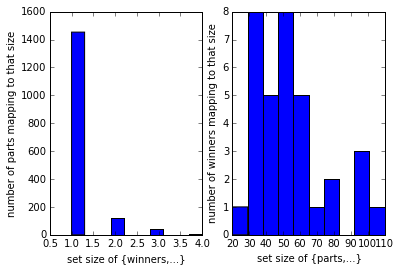

In [24]:
show(winners, losers)

What does this say?  First the table says that there are only three regexes that have 4 winners; all the rest have 3 or fewer winners.  So the links going left-to-right are rather sparse.  There are more links going the other direction; 110 to `van-buren`, for example.  The histograms give the whole picture mapping set sizes to the number of keys that have that set size.  So, on the left we see that over 1400 regexes have a set size of one winner, and 100 or fewer have set sizes of 2 and 3, and we saw that only 3 regexes have a set size of 4 winners.  On the right, the histogram shows a wide spread of winners that have set sizes between 1 and 110 regexes.

From looking at this I get two ideas:
    
+ I notice that both `'oo..'` and `'oo.'` happen to match 3 winners. But even if I didn't know how many they matched, I would know that the winners matched by `'oo..'` must be a subset of the winners matched by `'oo.'` (remember that a set is a subset of itself). Furthermore, `'oo.'` is shorter.  This suggests that we would *never* want to use  `'oo..'` in a solution, because we could always make the solution one character shorter (and cover at least all the same winners) by substituting `'oo.'`.  We say that * part A dominates B* if *A* is shorter and matches a superset of winners. We might as well throw out all dominated parts right at the start.

+ It might be a good idea to pay special attention to the characters, like `'-'`, that appear in the winners but not the losers.

Let's look at another example:

E.S$     41 | 186| SOFT COATED WHEATEN TERRIERS
RS$      34 | 184| STAFFORDSHIRE BULL TERRIERS
ERS$     34 | 175| GREATER SWISS MOUNTAIN DOGS
.RS$     34 | 162| TREEING WALKER COONHOUNDS
IE.S     22 | 157| CAVALIER KING CHARLES SPANIELS
E.RI     21 | 149| AMERICAN STAFFORDSHIRE TERRIERS
T..R     20 | 147| WEST HIGHLAND WHITE TERRIERS
IER.     19 | 146| STANDARD SCHNAUZERS
IER      19 | 146| FLAT-COATED RETRIEVERS
I.R.     19 | 146| CHESAPEAKE BAY RETRIEVERS
TOTAL  4570 | 100 TOTAL


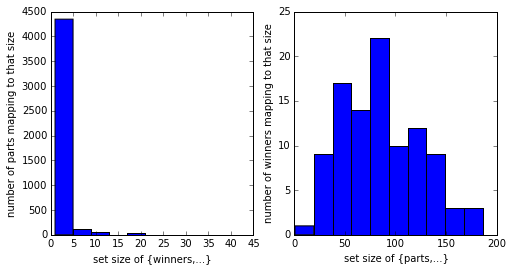

In [25]:
show(dogs, cats)

My immediate reaction to this is "there are a lot of retrievers and terriers."  All ten of the parts in the table recognize this fact, but the left-hand histogram shows that almost all the parts match fewer than 5 dog breeds. In contrast, the right-hand histogram shows that most of the dog breeds have 9 or more parts that match them.

Let's look at one more example:

a.l      12 |  94| especially
a.ly     11 |  83| eventually
a.l.     11 |  74| particularly
.a.l     11 |  67| actually
ll        9 |  65| quickly
^..$      9 |  65| exactly
.ll       9 |  65| directly
..ll      8 |  63| certainly
all       7 |  61| usually
st$       6 |  57| recently
TOTAL  2049 |  98 TOTAL


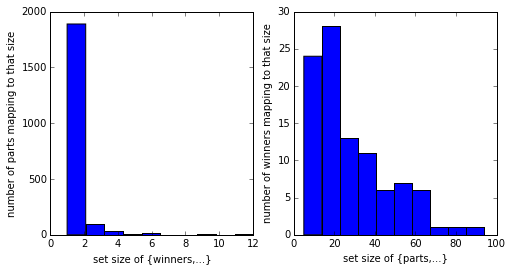

In [26]:
show(adverbs, nouns)

The pattern looks similar here.  Almost all the parts match only one winner, but most of the winners are matched by many parts. What can I conclude from this?

+ It would be good to think of new types of parts that match more winners.
+ Most parts are 2 or 3 characters long and most match just 1 or 2 winners.  That suggests that often we will have a tie in the `score` function, and greedy search will arbitrarily pick the one that comes first. But I'm worried that another choice might be better. Maybe we should replace greedy search with something that considers more than one choice.

Given all we've seen, I will shift my attention to understanding the search algorithm we have, and thinking about how to improve it.

# Analyzing: Understanding Greedy vs. Exhaustive Search

`findregex` is a *greedy search* algorithm. In general, greedy search is used when you are trying to find a solution that is composed of parts.  On each iteration you choose a part that looks good, and you never reconsider that choice;  you just keep on adding parts until you get a complete solution.   

The pseudo-code for a general `greedy_search`, described as a recursive function, is given below. It takes two arguments: a set of parts, and a partial solution indicating parts that have previously been chosen.  

In [27]:
# Pseudocode 
def greedy_search(parts, partial_solution=None):
    if is_complete(partial_solution):
        return partial_solution
    else:
        best = max(parts, key=score)
        return greedy_search(parts - {best}, partial_solution + best)

An *exhaustive search* considers *every* possible choice of parts, and selects the best solution.  On each iteration exhaustive search picks a part (just like greedy search), but then it considers *both* using the part and not using the part. You can see that exhaustive search is almost identical to greedy search, except that it has *two* recursive calls (on lines 7 and 8) instead of *one* (on line 7).  (*If you are viewing this in a IPython notebook, not just a web page, you can toggle line numbers by pressing 'ctrl-M L' within a cell.*) How do we choose between the results of the two calls?  We need a cost function that we are trying to minimize. (For regex golf the cost of a solution is the length of the string.)

In [28]:
# Pseudocode
def exhaustive_search(parts, partial_solution=None):
    if is_complete(partial_solution):
        return partial_solution
    else:
        best = max(parts, key=score)
        return min(exhaustive_search(parts - {best}, partial_solution + best),
                   exhaustive_search(parts - {best}, partial_solution),
                   key=cost)

Here's an interesting piece of trivia: the first thing that exhaustive search does is a greedy search!  Think about it: on each recursive call, `exhaustive_search` selects the best part, and then calls itself recursively with `best` chosen as part of the partial solution.  It keeps going until it reaches a complete solution.  That's exactly what greedy search does. But then exhaustive search does more:  It also considers all the cases where it *didn't* choose the best part.

Here's something else to ponder: why should we bother with selecting the "best" part?  If we're going to explore *all* possibilities, wouldn't it be the same if we just selected *any* part, not the "best" one?

# Searching: Computational Complexity of Greedy and Exhaustive Search


Greedy search only considers one path towards the goal of finding a solution. Exhaustive search considers two paths on *every* iteration.  How much work is that all together? If there are *P* parts, then there are $2^P$ subsets of parts. Now, we don't have to consider every one of these subsets, because the search ends when we cover all the winners.  If there are $W$ winners, than an upper bound on the number of combinations we have to consider is the number of ways we can pick $W$ parts from a pool of $P$, which in math we write as  ($P$ choose $W$).  For the presidential candidates  $W$, is 34, and $P$ is 1615.

So exhaustive search would have to consider roughly [(1615 choose 34)](https://www.google.com/search?q=1615+choose+34) = $10^{70}$ combinations, which is clearly too many. Don't even think about dogs versus cats, where $W$ = 100 and $P$ = 4570, so [(4570 choose  100)](https://www.google.com/search?q=4570+choose+100) = $10^{207}$. Fortunately, there is another way.

# Searching: Branch and Bound Search

[*Branch and bound*](http://en.wikipedia.org/wiki/Branch_and_bound) is a search strategy that gets the same answer as exhaustive search, but runs faster because it avoids considering many combinations that could not possibly lead to an optimal solution.  Here's how and why it works:

- The *branch* part of the name means that, just like exhaustive search, on each iteration it picks a part, and considers two branches, one where the part is in the solution, and one where it is not.  
- The *bound* part of the name means that the algorithm continually keeps track of the lowest-cost solution it has found so far.  This serves as a *bound* on what the optimal solution can be.
- The *trick* is to notice that the cost of a partial solution always *increases* as we add more parts to it.  Therefore, if we ever get to a partial solution whose cost is more than the lowest-cost solution we have found so far, then we can *immediately* discard the partial solution, and *never consider* all the other combinations that would have come from continuing the partial solution. If there are $MP$ parts left to consider, that means we just eliminated $2^P$ potential combinations all at once. "Eliminating potential combinations" is also called "pruning the search tree"&mdash;"[pruning](https://www.google.com/search?q=pruning)" means cutting off unwanted branches.

The pseudocode below uses a global variable called `CHEAPEST` to hold the lowest-cost solution found so far.  Note that the two branches (two recursive calls in lines 7 and 8) communicate through this global variable.  If the first branch sets `CHEAPEST` to an improved solution, then the second branch will see it.  That is why it is important to choose good "best" parts&mdash;it means we are more likely to find a good solution early on, which makes it more likely that we can prune away branches.  

In [29]:
# Pseudocode
def branch_and_bound_search(parts, partial_solution=None):
    if is_complete(partial_solution):
        CHEAPEST = min(CHEAPEST, partial_solution, key=cost)
    elif cost(partial_solution) < cost(CHEAPEST):
        best = select_best(parts)
        branch_and_bound_search(parts - {best}, partial_solution + best)
        branch_and_bound_search(parts - {best}, partial_solution)
    return CHEAPEST



# Searching: Anytime Branch and Bound Search

Even with all this pruning, we still may be presented with problems that require trillions of recursive calls.  [Who's got that kind of time?](http://www.gocomics.com/calvinandhobbes/1995/08/17#.UvSJImSwI8g)  But if we stop the algorithm at any time, we still have our best solution stored in `CHEAPEST`. Algorithms that have the property that an answer is always available are called [*anytime algorithms*](http://en.wikipedia.org/wiki/Anytime_algorithm); let's do that.

I can think of two easy ways to allow early stopping.  We could use the [`threading.Timer`](http://docs.python.org/2/library/threading.html#timer-objects) class to  run the search for a given number of seconds, then stop.  Or we could have a counter which gets decremented every time we make a call, and when it hits zero, stop.  I'll use the second approach.

Enough pseudocode&mdash;here is a real implementation.  Since global variables are [considered bad style](https://google.github.io/styleguide/pyguide.html#Global_variables), I decided to use a class, `BranchBound`, to hold the lowest-cost solution and the number of calls remaining.  The class provides one method, `search`, which does the work.

In [30]:
class BranchBound(object):
    "Hold state information for a branch and bound search."
    def __init__(self, winners, max_num_calls, k=4):
        self.cheapest = trivial(winners)
        self.calls    = max_num_calls
        self.k        = k
        
    def search(self, covers, partial=None):
        """Recursively extend partial regex until it matches all winners in covers.
        Try all reasonable combinations until we run out of calls."""
        if self.calls <= 0: 
            return self.cheapest
        self.calls -= 1
        covers, partial = simplify_covers(covers, partial)
        if not covers: # Nothing left to cover; solution is complete
            self.cheapest = min(partial, self.cheapest, key=len)
        elif len(OR(partial, min(covers, key=len))) < len(self.cheapest):
            def score(p): return self.k * len(covers[p]) - len(p)
            best = max(covers, key=score) # Best part
            covered = covers[best] # Set of winners covered by best
            covers.pop(best)
            # Try with and without the greedy-best part
            self.search({c:covers[c]-covered for c in covers}, OR(partial, best))
            self.search(covers, partial)
        return self.cheapest

# Simplifying Covers

There's a new function introduced above, `simplify_covers`.  The idea is that you pass it a `covers` dict and a partial regex, and it does a triage process to divide the components in `covers` into three categories:

- *Useless components*: could never appear in an optimal solution.
- *Necessary components*: must appear in any solution (because no other component covers some winner).
- *Remaining components*: neither useless nor necessary.
    
The necessary components are joined to the partial regex that is passed in, to yield a new partial regex that the function returns.  The useless components are eliminated, and the remaining ones are returned in a new `covers` dict.  

`simplify_covers` works by first eliminating useless components, and then selecting necessary components.  We keep repeating this process of eliminating and selecting until there are no more changes to `covers`:

In [31]:
def simplify_covers(covers, partial=None):
    "Eliminate dominated regexes, and select ones that uniquely cover a winner."
    previous = None
    while covers != previous:
        previous = covers
        covers = eliminate_dominated(covers)
        covers, necessary = select_necessary(covers)
        partial = OR(partial, necessary)
    return covers, partial

For convenience we modified the function `OR` slightly; we made it work just like the function `max` in that you can call it two ways: either with a single argument, which is a collection of components, or with 2 or more arguments, each a component. We also made it ignore components that are `None`, so that `OR(None, 'a')` equals `'a'`, but `OR('a', 'b')` equals `'a|b'`, as does `OR(['a', 'b'])`

In [32]:
def OR(*regexes):
    """OR together component regexes. Ignore 'None' components.
    Allows both OR(a, b, c) and OR([a, b, c]), similar to max."""
    if len(regexes) == 1: 
        regexes = regexes[0]
    return '|'.join(r for r in regexes if r)

# Simplifying Covers: Eliminating Dominated Components

We defined the notion of a regex being *dominated* if there is some other regex that is shorter (or at least not longer) and covers a superset of winners. How can we efficiently compute which parts are dominated? Here's one simple approach: go through each regex part, `p`, and every time we find one that is not dominated by any another regex part `p2`, add `p` (and its winners) to a new dict that we are building up.  This approach works, but it is $O(n^2)$.

Here's an alternative that is faster: First, sort all the regexes so that the ones that match more winners come first (in case of tie, put the shorter ones first).  (In other words, "best" first.)   Initialize a new dict to empty, and go through the sorted regexes, `p`, one at a time.  For each `p`, compare it only to the regexes, `p2`, that we have already added to the new dict; if none of them dominate `p`, then add `p`. This is still $O(n^2)$, but if, say, 99 out of 100 regexes are eliminated, we will only need $n^2/100$ comparisons.

The code for `eliminate_dominated` is a slight variant on the [version](https://github.com/pochmann/regex-golf) by Stefan Pochmann (because his version turned out to be better than my first version). Note that the function `signature` represents a regex as a pair of numbers, the negative of the number of winners and the length in characters.  The smaller (in lexicographical order) this pair is, the "better" the regex is.  Why is it important to put the regexes in sorted order?  So that we know that the only possible dominators are the ones that came *before*, not ones that come after. Note that, as we are going through the component regexes, `p`, in sorted order, if we ever hit a `p` that covers no winners, then we know that all the remaining `p` will also cover no winners (because we're going in best-first order), so we can break out of the loop immediately. And one more thing: the expression `covers[p2] >= covers[p]` asks if `p2` covers a superset of the winners that `p` covers.

In [33]:
def eliminate_dominated(covers):
    """Given a dict of {regex: {winner...}}, make a new dict with only the regexes
    that are not dominated by any others. A regex part p is dominated by p2 if p2 covers 
    a superset of the matches covered by p, and rp is shorter."""
    newcovers = {}
    def signature(p): return (-len(covers[p]), len(p))
    for p in sorted(covers, key=signature):
        if not covers[p]: break # All remaining r must not cover anything
        # r goes in newcache if it is not dominated by any other regex
        if not any(covers[p2] >= covers[p] and len(p2) <= len(p) 
                   for p2 in newcovers):
            newcovers[p] = covers[p]
    return newcovers

# Simplifying Covers: Selecting Necessary Components


If some winner is covered by only one part, then we know that part must be part of the solution.  The function `select_necessary` finds all such parts, `OR`s them together, and returns that, along with a dict of the remaining covers, after removing the necessary parts (and removing all the winners that are covered by the neccessary parts).

In [34]:
def select_necessary(covers):
    """Select winners covered by only one part; remove from covers.
    Return a pair of (covers, necessary)."""
    counts = Counter(w for p in covers for w in covers[p])
    necessary = {p for p in covers if any(counts[w] == 1 for w in covers[p])}
    if necessary:
        covered = {w for p in necessary for w in covers[p]}
        covers = {p: covers[p] - covered 
                  for p in covers if p not in necessary}
        return covers, OR(necessary)
    else:
        return covers, None

# Testing and Benchmarking: Branch and Bound

Let's make up a test suite (showing some examples of how these functions work).  Then let's see if `findregex` works with the new branch and bound search. 

In [35]:
def test_bb():
    assert OR(['a', 'b', 'c']) == OR('a', 'b', 'c') == 'a|b|c'
    assert OR(['a|b', 'c|d']) == OR('a|b', 'c|d') == 'a|b|c|d'
    assert OR(None, 'c') == 'c'
    covers1 = {'a': {'ann', 'abe'}, 'ab': {'abe'}}
    assert eliminate_dominated(covers1) == {'a': {'ann', 'abe'}}
    assert simplify_covers(covers1) == ({}, 'a')
    covers2 = {'a': {'abe', 'cab'}, 'b': {'abe', 'cab', 'bee'}, 
               'c': {'cab', 'cee'}, 'c.': {'cab', 'cee'}, 'abe': {'abe'},
               'ab': {'abe', 'cab'}, '.*b': {'abe', 'cab', 'bee'}, 
               'e': {'abe', 'bee', 'cee'}, 'f': {}, 'g': {}}
    assert eliminate_dominated(covers2) == simplify_covers(covers2)[0] == {
        'c': {'cab', 'cee'}, 'b': {'cab', 'abe', 'bee'}, 'e': {'cee', 'abe', 'bee'}}
    covers3 = {'1': {'w1'}, '.1': {'w1'}, '2': {'w2'}}
    assert eliminate_dominated(covers3) == {'1': {'w1'}, '2': {'w2'}}
    assert simplify_covers(covers3) in (({}, '2|1'), ({}, '1|2'))
    covers, nec = select_necessary({'a': {'abe'}, 'c': {'cee'}})
    assert covers == {} and (nec == 'c|a' or nec == 'a|c')
    assert {0, 1, 2} >= {1, 2}
    assert {1, 2} >= {1, 2}
    assert not ({1, 2, 4} >= {1, 3})
    return 'test_bb passes'

test_bb()

'test_bb passes'

Let's investigate how much the cover simplification process is helping:

In [36]:
covers = regex_covers(winners, losers)
len(covers)

1615

In [37]:
covers2, partial = simplify_covers(covers)
len(covers2)

49

In [38]:
1 - len(covers2)/len(covers)

0.9696594427244583

We see that `simplify_covers` gives us a 97% reduction in the number of parts! What do the remaining covers look like?

In [39]:
simplify_covers(covers)

({'-': frozenset({'van-buren'}),
  '.b': frozenset({'obama', 'van-buren'}),
  '.f': frozenset({'garfield', 'taft'}),
  '.h.n': frozenset({'buchanan', 'washington'}),
  '.se': frozenset({'eisenhower', 'roosevelt'}),
  'a..i': frozenset({'garfield', 'harding', 'harrison', 'washington'}),
  'a.a': frozenset({'adams', 'buchanan', 'obama', 'reagan'}),
  'a.t': frozenset({'carter', 'grant', 'taft'}),
  'ad': frozenset({'adams', 'madison'}),
  'am': frozenset({'adams', 'obama'}),
  'an.$': frozenset({'cleveland', 'grant'}),
  'ay.': frozenset({'hayes', 'taylor'}),
  'bu': frozenset({'buchanan', 'bush', 'van-buren'}),
  'di': frozenset({'harding', 'madison'}),
  'ed': frozenset({'kennedy'}),
  'el.$': frozenset({'garfield', 'roosevelt'}),
  'g..n': frozenset({'grant', 'washington'}),
  'ga': frozenset({'garfield', 'reagan'}),
  'h..e': frozenset({'eisenhower', 'hayes'}),
  'ho': frozenset({'eisenhower', 'hoover'}),
  'i..n': frozenset({'eisenhower', 'harrison', 'madison', 'nixon'}),
  'i..o': 

 Now let's benchmark  branch and bound.  I'm going to introduce a modified version of `benchmark`, called `bbenchmark`, to print the number of calls taken. The easiest way to do that is to introduce a new version of `findregex`, called `bb_findregex`, that returns the `BranchBound` object it creates, rather than returning the solution. (In general, I tend to introduce a new function when I change the call/return signature, but not when I just improve the mechanism.)

In [40]:
def bbenchmark(examples=EXAMPLES, calls=10**4): 
    "Run these data sets; print summaries; return total of solution lengths."
    totalchars = 0
    for (W, Wname, Lname, L) in examples: # Do both ways
        re.purge()
        bb = bb_findregex(W, L, calls)
        SOLUTION[W, L] = bb.cheapest
        assert not mistakes(bb.cheapest, W, L)
        legend = '{}({}):{}({})'.format(Wname, len(W), Lname, len(L))
        print('{:20} {:6} calls, {:3}: "{}"'.format(
              legend, (calls - bb.calls), len(bb.cheapest),  truncate(bb.cheapest, 45)))
        totalchars += len(bb.cheapest)
    return totalchars

def bb_findregex(winners, losers, calls=10**4):
    "Return a BranchBound object which contains the shortest regex that covers winners but not losers."
    bb = BranchBound(winners, calls)
    bb.search(regex_covers(winners, losers))
    return bb

def findregex(winners, losers): return bb_findregex(winners, losers).cheapest

Remember, the old benchmark took about 5 seconds and totaled 1749 characters. Let's see how the branch and bound benchmark compares:

In [41]:
%time bbenchmark(calls=1000)

win(34):lose(34)       1000 calls,  52: "j|po|a.a|a..i|bu|ma|li|ls|a.t|vel|ho|xo|a ..."
lose(34):win(34)       1000 calls,  58: "^s|ox|ss|^ki|^d|go|^.re|hu|ry|ai|k..$|n.y ..."
boy(10):girl(10)          9 calls,  11: "de|a.$|c|as"
girl(10):boy(10)         13 calls,  10: "a$|a.i|e.i"
drug(10):city(10)         3 calls,  15: "ir|^e|o.$|f|x|q"
city(10):drug(10)        17 calls,  11: "ri|an|h|a.e"
foo(21):bar(21)           1 calls,   3: "f.o"
bar(21):foo(21)         205 calls,  24: "k|ld|b|...n|ah|ar|or|z|A"
wars(6):trek(9)          21 calls,   9: " T|E..H|B"
trek(9):wars(6)           9 calls,  13: "IS|Y|RA|CT| F"
noun(100):adj(98)      1000 calls, 167: "f.t|^hea|aw$|^g|jo|rty|rt$|ot$|^wa|o.y|el ..."
adj(98):noun(100)       721 calls, 146: "r.t|re$|f$|st$|at$|rse|b.t|a.l|ui|far|u.h ..."
noun(100):verb(94)     1000 calls, 168: "am|er$|t.t|ir|po|ot|.as|^ar|^en|gu|.ne|ac ..."
verb(94):noun(100)     1000 calls, 170: "c.n|p.y|sw|r.ad|^tr|ru|^fi|un.$|it$|b.y|^ ..."
rand(58):built(147)    1000 call

1676

This is encouraging! We took about 2 seconds longer, but improved on the total number of characters by about 4%. For 10 of the 22 cases we didn't reach the cutoff of 1000 calls, which means that we searched every feasible combination of the parts we have.  Let's try with 10,000 calls:

In [42]:
%time bbenchmark(calls=10000)

win(34):lose(34)       1707 calls,  52: "j|po|a.a|a..i|bu|ma|li|ls|a.t|vel|ho|xo|a ..."
lose(34):win(34)       3075 calls,  57: "^s|ox|ss|^ki|i.$|go|^f|de|br|hu|ker|le$|e ..."
boy(10):girl(10)          9 calls,  11: "de|a.$|c|as"
girl(10):boy(10)         13 calls,  10: "a$|a.i|e.i"
drug(10):city(10)         3 calls,  15: "ir|^e|o.$|f|x|q"
city(10):drug(10)        17 calls,  11: "ri|an|h|a.e"
foo(21):bar(21)           1 calls,   3: "f.o"
bar(21):foo(21)         205 calls,  24: "k|ld|b|...n|ah|ar|or|z|A"
wars(6):trek(9)          21 calls,   9: " T|E..H|B"
trek(9):wars(6)           9 calls,  13: "IS|Y|RA|CT| F"
noun(100):adj(98)      2009 calls, 167: "f.t|^hea|aw$|^g|jo|rty|rt$|ot$|^wa|o.y|el ..."
adj(98):noun(100)       721 calls, 146: "r.t|re$|f$|st$|at$|rse|b.t|a.l|ui|far|u.h ..."
noun(100):verb(94)    10000 calls, 168: "am|er$|t.t|ir|po|ot|.as|^ar|^en|gu|.ne|ac ..."
verb(94):noun(100)     3285 calls, 170: "c.n|p.y|sw|r.ad|^tr|ru|^fi|un.$|it$|b.y|^ ..."
rand(58):built(147)    1427 call

1674

We doubled the time and gained a few characters. How about 100,000 calls?

In [43]:
%time bbenchmark(calls=100000)

win(34):lose(34)       1707 calls,  52: "j|po|a.a|a..i|bu|ma|li|ls|a.t|vel|ho|xo|a ..."
lose(34):win(34)       3075 calls,  57: "^s|ox|ss|^ki|i.$|go|^f|de|br|hu|ker|le$|e ..."
boy(10):girl(10)          9 calls,  11: "de|a.$|c|as"
girl(10):boy(10)         13 calls,  10: "a$|a.i|e.i"
drug(10):city(10)         3 calls,  15: "ir|^e|o.$|f|x|q"
city(10):drug(10)        17 calls,  11: "ri|an|h|a.e"
foo(21):bar(21)           1 calls,   3: "f.o"
bar(21):foo(21)         205 calls,  24: "k|ld|b|...n|ah|ar|or|z|A"
wars(6):trek(9)          21 calls,   9: " T|E..H|B"
trek(9):wars(6)           9 calls,  13: "IS|Y|RA|CT| F"
noun(100):adj(98)      2009 calls, 167: "f.t|^hea|aw$|^g|jo|rty|rt$|ot$|^wa|o.y|el ..."
adj(98):noun(100)       721 calls, 146: "r.t|re$|f$|st$|at$|rse|b.t|a.l|ui|far|u.h ..."
noun(100):verb(94)   100000 calls, 167: "am|er$|t.t|ir|po|ot|.as|^ar|^en|gu|.ne|ac ..."
verb(94):noun(100)     3285 calls, 170: "c.n|p.y|sw|r.ad|^tr|ru|^fi|un.$|it$|b.y|^ ..."
rand(58):built(147)    1427 call

1669

We're slowly decreasing the total number of characters, but at the expense of increasing run time. I think if we want to make more progress, it is time to stop worrying about the search algorithm, and start worrying about what we're searching over.

# New Parts: Repetition Characters

Following a suggestion by Stefan Pochmann, I will generate two new classes of parts that use the repetition characters `'*'`, `'+'`, and `'?'`:

- **pairs**: parts of the form `'A.*B'` where `'A'` and `'B'` are any two non-special characters that appear anywhere in any winner, the dot is always the second character, and the third character is one of the repetition characters. 

- **reps**: given a part such as `'a.c'`, insert any repetition character after any character in the part (yielding, for example, `'a*.c'`).
Don't insert after `'^'` or `'$'`, and don't allow redundant parts like `'..*c'`.


Here is a new version of `regex_covers` that adds the new parts:

In [44]:
def regex_covers(winners, losers):
    """Generate regex components and return a dict of {regex: {winner...}}.
    Each regex matches at least one winner and no loser."""
    losers_str = '\n'.join(losers)
    wholes = {'^'+winner+'$' for winner in winners}
    parts  = {d for w in wholes for p in subparts(w) for d in dotify(p)}
    reps   = {r for p in parts for r in repetitions(p)}
    pool   = wholes | parts | pairs(winners) | reps                         
    searchers = {p:re.compile(p, re.MULTILINE).search for p in pool}
    return {p: Set(filter(searchers[p], winners)) 
            for p in pool
            if not searchers[p](losers_str)}

def pairs(winners, special_chars=Set('*+?^$.[](){}|\\')):
    chars = Set(cat(winners)) - special_chars
    return {A+'.'+q+B 
            for A in chars for B in chars for q in '*+?'}

def repetitions(part):
    """Return a set of strings derived by inserting a single repetition character
    ('+' or '*' or '?'), after each non-special character.  
    Avoid redundant repetition of dots."""
    splits = [(part[:i], part[i:]) for i in range(1, len(part)+1)]
    return {A + q + B 
            for (A, B) in splits
            # Don't allow '^*' nor '$*' nor '..*' nor '.*.'
            if not (A[-1] in '^$')
            if not A.endswith('..')
            if not (A.endswith('.') and B.startswith('.'))
            for q in '*+?'}

In [45]:
def test_new_parts():
    assert repetitions('a') == {'a+', 'a*', 'a?'}
    assert repetitions('ab') == {'a+b', 'a*b', 'a?b', 
                                 'ab+', 'ab*', 'ab?'}
    assert repetitions('a.c') == {'a+.c', 'a*.c', 'a?.c',
                                  'a.c+', 'a.*c', 'a.?c',
                                  'a.+c', 'a.c*', 'a.c?'}
    assert repetitions('^a..d$') == {'^a+..d$', '^a*..d$', '^a?..d$', 
                                     '^a..d+$', '^a..d*$', '^a..d?$'}
    assert pairs({'ab', 'c'}) == {
        'a.*a', 'a.*b', 'a.*c',
        'a.+a', 'a.+b', 'a.+c',
        'a.?a', 'a.?b', 'a.?c',
        'b.*a', 'b.*b', 'b.*c',
        'b.+a', 'b.+b', 'b.+c',
        'b.?a', 'b.?b', 'b.?c',
        'c.*a', 'c.*b', 'c.*c',
        'c.+a', 'c.+b', 'c.+c',
        'c.?a', 'c.?b','c.?c'}
    assert len(pairs({'1...2...3', '($2.34)', '42', '56', '7-11'})) == 8 * 8 * 3
    covers = regex_covers({'one', 'on'}, {'won', 'wuan', 'juan'})
    assert (eliminate_dominated(covers) == {'e': {'one'}, '^o': {'on', 'one'}})
    return 'test_new_parts passes'

test_new_parts()

'test_new_parts passes'

Let's take our new parts out for a spin and see what they can do:

In [46]:
findregex(starwars, startrek)

' T|P.*E'

**Awesome!**  

Remember, Randall had a ten character regex in the strip (see below); we previously got it down to nine, but we now have it down to **seven** with `' T|P.*E'`!

<img src="http://norvig.com/regex_golf1.PNG">

**Update(Nov 2015)**: There are two new movies in the works; let's see what they do to our golf score:

In [47]:
starwars = starwars | {'THE FORCE AWAKENS'}
startrek = startrek | {'BEYOND'}

findregex(starwars, startrek)

' T|P.*E|KE'

Too bad; back to ten characters.

How much more work are we doing with these additional parts?  Before, `regex_covers(winners, losers)` gave 1615 regexes, which were reduced to 49 by `simplify_covers`.  Now:

In [48]:
covers = regex_covers(winners, losers)
len(covers)

13200

In [49]:
covers2, partial = simplify_covers(covers)
len(covers2)

90

So the total number of regexes is increased almost 10-fold, but after simplification the number is only  double what it was before.  (To put it another way, `simplify_covers` eliminated 99.3% of the parts.) That's not too bad; let's add *more* components.

# New Parts: Longer Ones

Previously we generated parts of length up to 4 characters.  Why not say "[we're doing 5](http://www.theonion.com/articles/fuck-everything-were-doing-five-blades,11056/)"?  The implementation is easy:



In [50]:
SUBPARTS = 5 # Maximum length of a subpart

def subparts(word):
    "Return a set of subparts of word, consecutive characters up to length 5."
    return set(word[i:i+1+s] for i in range(len(word)) for s in range(SUBPARTS)) 

But how many more regex components does this give us?

In [51]:
covers = regex_covers(winners, losers)
len(covers)

39537

In [52]:
covers2, partial = simplify_covers(covers)
len(covers2)

112

In the end the longer parts add only 22 new components, rejecting nearly 40,000 other parts. It is time to benchmark again. Remember our previous best was Branch and Bound with 100,000 calls, which yielded 1669 total characters in 170 seconds.

In [53]:
%time bbenchmark(calls=1000)

win(34):lose(34)       1000 calls,  47: "i.+o|o.*o|a.a|po|a.t|j|bu|ce|ay.|ma|r.i|n ..."
lose(34):win(34)       1000 calls,  56: "r.*y|i.e*$|^s|go|d..e|^f|n.*k|k.+g|hu|rk| ..."
boy(10):girl(10)         29 calls,  11: "a.$|de|c|as"
girl(10):boy(10)         23 calls,   9: "a$|^m*..i"
drug(10):city(10)        85 calls,  15: "o.$|x|ir|f|q|^e"
city(10):drug(10)        45 calls,  11: "ri|a.+e|h|k"
foo(21):bar(21)           1 calls,   3: "foo"
bar(21):foo(21)        1000 calls,  23: "^...a|k|...n|ld|b|ar|or"
wars(6):trek(9)          23 calls,   7: " T|P.*E"
trek(9):wars(6)         169 calls,  12: "I.?S|RA| F|Y"
noun(100):adj(98)      1000 calls, 161: "^wa|l.v|m.+n|me?$|.i.*d|....o|an*.e$|..k$ ..."
adj(98):noun(100)      1000 calls, 140: "e.+y|^..l*$|l.*s|rs?e$|a.l|ei?t|st$|en$|f ..."
noun(100):verb(94)     1000 calls, 168: "h.+g|mp*.n|p.*r|..h.|mb*e|ea?s|^k?i|.ne|. ..."
verb(94):noun(100)     1000 calls, 162: "rr|tar|o.b|^..p?l|^f?..$|buy|f$|^fi|as*k| ..."
rand(58):built(147)    1000 calls,  7

1616

We reduced the total characters by about 4%, although it did take longer, even with only 1,000 calls. And notice we no longer need `'^HAVANESE$'`; instead we have `'H.*N.S'`, which saves 4 characters, and, look how many breeds it matches:

In [54]:
matches('H.*N.S', dogs)

{'AFGHAN HOUNDS',
 'BASSET HOUNDS',
 'BLOODHOUNDS',
 'CHINESE CRESTED',
 'CHINESE SHAR-PEI',
 'DACHSHUNDS',
 'HAVANESE',
 'IRISH WOLFHOUNDS',
 'ITALIAN GREYHOUNDS',
 'TREEING WALKER COONHOUNDS'}

Let's continue benchmarking:

In [55]:
%time bbenchmark(calls=10000)

win(34):lose(34)      10000 calls,  46: "i.+o|j|bu|oo|a.t|n.o*e|ma|po|ie.|ay.|e.?a ..."
lose(34):win(34)      10000 calls,  55: "r.*y|i.e*$|^s|go|de|do|^f|la.$|al|n.*k|k. ..."
boy(10):girl(10)         29 calls,  11: "a.$|de|c|as"
girl(10):boy(10)         23 calls,   9: "a$|^m*..i"
drug(10):city(10)        85 calls,  15: "o.$|x|ir|f|q|^e"
city(10):drug(10)        45 calls,  11: "ri|a.+e|h|k"
foo(21):bar(21)           1 calls,   3: "foo"
bar(21):foo(21)        6151 calls,  23: "^...a|k|...n|ld|b|ar|or"
wars(6):trek(9)          23 calls,   7: " T|P.*E"
trek(9):wars(6)         169 calls,  12: "I.?S|RA| F|Y"
noun(100):adj(98)     10000 calls, 160: "^wa|l.v|m.+n|me?$|.i.*d|....o|an*.e$|..k$ ..."
adj(98):noun(100)     10000 calls, 136: "e.+y|^..l*$|l.*s|rs?e$|a.l|ei?t|st$|en$|f ..."
noun(100):verb(94)    10000 calls, 167: "h.+g|mp*.n|p.*r|..h.|mb*e|ea?s|^k?i|.ne|. ..."
verb(94):noun(100)    10000 calls, 162: "rr|tar|o.b|^..p?l|^f?..$|buy|f$|^fi|as*k| ..."
rand(58):built(147)   10000 calls,  6

1596

We're making good progress. What next? We now have so many parts, that many of the searches do not complete. Suppose one of our first choices was wrong, and the search took a part that does not belong in an optimal solution.  We might well spend all our calls on the half of the search tree that keeps the part, never exploring a part of the tree without it.  I'd like to alter the search algorithm to get us out of that rut.

# Searching: Random Restart


One way out of the rut is to run the search for a while, then stop it, and run a different search, that explores a different part of the search space. This is called a *random restart search*. How do we get a *different* search when we restart? I can think of two easy things to vary:
    
+ The '4' in the `score` function. That is, vary the tradeoff between number of winners matched and number of characters in a regex.
+ The tie-breaker. In case of a tie on `max(covers, key=score)`, Python always picks the first component. Let's make it choose a different one each time.

The first of these is easy; we can use the `random.choice` function to choose an integer, K, to serve as the tradeoff factor. The second is easy too. We could write an alternative to the `max` function, say `max_random_tiebreaker`. That would work, but an easier approach is to build the tiebreaker into the `score` function. In addition to awarding points for matching winners, and subtracting a point for each character in the solution, we will have `score` add in a random number. We'll call this the "fuzz factor" and use the variable `F` to determine how big it is.  If the fuzz factor is a random number between 0 and 1, then all it does is serve as a tiebreaker.  But if it is a random number that can be larger than 1, then sometimes it will cause `max` to pick a best part that does not have quite the best score.  We're not sure how much randomness is best, so we'll let the values of `K` and `F` vary from one choice to the next.

In [56]:
def bb_findregex(winners, losers, calls=10000, restarts=10):
    "Find the shortest disjunction of regex components that covers winners but not losers."
    bb = BranchBoundRandomRestart(winners, calls)
    covers = eliminate_dominated(regex_covers(winners, losers))
    for _ in range(restarts):
        bb.calls = calls
        bb.search(covers.copy())
        if bb.calls > 0: # If search was not cut off, we have optimal solution
            return bb 
    return bb

class BranchBoundRandomRestart(BranchBound):
    def search(self, covers, partial=None):
        """Recursively extend partial regex until it matches all winners in covers.
        Try all reasonable combinations until we run out of calls."""
        if self.calls <= 0: 
            return partial, covers
        self.calls -= 1
        covers, partial = simplify_covers(covers, partial)
        if not covers: # Nothing left to cover; solution is complete
            self.cheapest = min(partial, self.cheapest, key=len)
        elif len(OR(partial, min(covers, key=len))) < len(self.cheapest):
            # Try with and without the greedy-best component
            K = random.choice((2, 3, 4, 4, 4, 5, 6))
            F = random.choice((0.1, 0.1, 2.0))
            def score(c): return K * len(covers[c]) - len(c) + random.uniform(0., F)
            best = max(covers, key=score) # Best component
            covered = covers[best] # Set of winners covered by r
            covers.pop(best)
            self.search({c:covers[c]-covered for c in covers}, OR(partial, best))
            self.search(covers, partial)
        return self.cheapest

In [57]:
%time bbenchmark(calls=100)  

win(34):lose(34)        100 calls,  49: "i.+o|o.*o|.f|ce|a.a|po|bu|ay.|ma|n.e|j|an ..."
lose(34):win(34)        100 calls,  52: "r.*y|^d|^s|go|m.+a|^f|....k|^.?la|ki*..$| ..."
boy(10):girl(10)         29 calls,  11: "a.$|c|de|as"
girl(10):boy(10)         21 calls,   9: "a$|^m*..i"
drug(10):city(10)        91 calls,  15: "o.$|x|ir|f|q|^e"
city(10):drug(10)        49 calls,  11: "ri|h|a.+e|k"
foo(21):bar(21)           1 calls,   3: "foo"
bar(21):foo(21)         100 calls,  23: "..r..|^...a|k|A|ld|...n"
wars(6):trek(9)          23 calls,   7: " T|P.*E"
trek(9):wars(6)         100 calls,  12: "I.?S|TI|H |Y"
noun(100):adj(98)       100 calls, 160: "^wa|l.v|m.+n|me?$|....o|.i.*d|ar*c.$|wo|. ..."
adj(98):noun(100)       100 calls, 128: "e.+y|^o*..$|l.*s|ll|rs?e$|ei?t|en$|st$|fa ..."
noun(100):verb(94)      100 calls, 163: "h.+g|mo?.n|p.*r|..h.|mb*e|t.*o|.ne|^k?i|f ..."
verb(94):noun(100)      100 calls, 161: "rr|tar|o.b|^..p?l|^s*..$|f$|buy|as*k|r.ad ..."
rand(58):built(147)     100 calls,  6

1564

Remember, when it says "100 calls" here, it really means 1,000 calls, because we are doing 10 random restarts. This looks very promising; even with only 100 calls per restart, we're doing better than 100,000 calls without restarts.  Let's continue:

In [58]:
%time bbenchmark(calls=1000)

win(34):lose(34)       1000 calls,  46: "i.+o|o.*o|bu|a.t|j|ma|po|ie.|n.e|ay.|ar*d ..."
lose(34):win(34)       1000 calls,  55: "r.*y|i.e*$|^s|go|de|^f|do|la.$|al|k.+g|hu ..."
boy(10):girl(10)         31 calls,  11: "a.$|de|c|as"
girl(10):boy(10)         21 calls,   9: "a$|^m*..i"
drug(10):city(10)        89 calls,  15: "o.$|x|ir|f|q|^e"
city(10):drug(10)        41 calls,  11: "ri|a.+e|h|k"
foo(21):bar(21)           1 calls,   3: "foo"
bar(21):foo(21)        1000 calls,  23: "^...a|k|...n|ld|b|or|ar"
wars(6):trek(9)          33 calls,   7: " T|P.*E"
trek(9):wars(6)         153 calls,  12: "I.?S|RA| F|Y"
noun(100):adj(98)      1000 calls, 159: "^wa|l.v|m.+n|me?$|....o|.i.*d|an*.e$|..k$ ..."
adj(98):noun(100)      1000 calls, 128: "e.+y|^o*..$|l.*s|ll|rs?e$|ei?t|st$|en$|fa ..."
noun(100):verb(94)     1000 calls, 162: "h.+g|mp*.n|p.*r|..h.|mb*e|^k?i|.ne|or.?$| ..."
verb(94):noun(100)     1000 calls, 159: "rr|tar|o.b|^..p?l|^s*..$|f$|buy|as*k|r.ad ..."
rand(58):built(147)    1000 calls,  6

1554

In [59]:
%time bbenchmark(calls=10000)

win(34):lose(34)      10000 calls,  46: "i.+o|o.*o|bu|a.t|j|ma|po|n.e|ay.|ar*d|e.? ..."
lose(34):win(34)      10000 calls,  52: "^d|r.*y|^s|go|m.+a|^f|^.?la|....k|ki*..$| ..."
boy(10):girl(10)         29 calls,  11: "a.$|de|c|as"
girl(10):boy(10)         21 calls,   9: "a$|^m*..i"
drug(10):city(10)       105 calls,  15: "x|o.$|ir|f|q|^e"
city(10):drug(10)        39 calls,  11: "ri|a.+e|h|k"
foo(21):bar(21)           1 calls,   3: "foo"
bar(21):foo(21)        6049 calls,  23: "^...a|k|...n|ld|b|ar|or"
wars(6):trek(9)          23 calls,   7: " T|P.*E"
trek(9):wars(6)         147 calls,  12: "I.?S|TI|H |Y"
noun(100):adj(98)     10000 calls, 158: "^wa|l.v|m.+n|me?$|....o|.i.*d|a.e$|..k$|^ ..."
adj(98):noun(100)     10000 calls, 128: "e.+y|^o*..$|ll|l.*s|rs?e$|ei?t|en$|i..l|l ..."
noun(100):verb(94)    10000 calls, 163: "h.+g|mp*.n|p.*r|..h.|mb*e|^k?i|.ne|.t.*y| ..."
verb(94):noun(100)    10000 calls, 157: "rr|tar|o.b|^..p?l|^s*..$|f$|buy|as*k|r.ad ..."
rand(58):built(147)   10000 calls,  6

1550

Just One More Thing: Negative Lookahead
----

In the `foo` versus `bar` example, we have a big asymmetry in the solution lengths: three letter for `'foo'` compared to 23 characters in the other direction.  But if you are a real [regular expression superhero](https://xkcd.com/208/), then you might know about [*negative lookahead assertions*](http://docs.python.org/2/howto/regex.html#lookahead-assertions) and you could solve `bar` versus `foo` like this:                                                

In [60]:
not_foo = '^(?!.*foo)'
not mistakes(not_foo, bar, foo)

True

Whoa&mdash;what just happened there? The form `'^(?!.*foo)'` means "starting from the beginning of the line, look ahead for `'.*foo'` (that is, any number of characters followed by `'foo'`). If it is there, then fail, else succeeed." That's just what we need to match all the non-foo strings in the `bar` collection. Let's apply this idea to the complete benchmark and see how many characters we save.  We'll use the `SOLUTION` dict that was compiled by the previous call to  `benchmark`:

In [61]:
def consider_negative_lookahead(W, L): 
    "Return either SOLUTION[W, L] or negative lookup of SOLUTION[L, W], whichever is shorter."
    solution = min(SOLUTION[W, L], '^(?!.*(' + SOLUTION[L, W] + '))',
                   key=len)
    assert not mistakes(solution, W, L)
    return solution
    
%time sum(len(consider_negative_lookahead(W, L)) for (W, _, _, L) in EXAMPLES)

CPU times: user 15.8 ms, sys: 291 µs, total: 16.1 ms
Wall time: 16 ms


1429

Very nice! Almost a 10% improvement, and it took almost no additional time at all.  

# Summary of Results

Here is a plot of results. Note that every time you re-run this notebook, the timing and the exact number of characters will vary a little; these numbers reflect rrsults from a previous run.


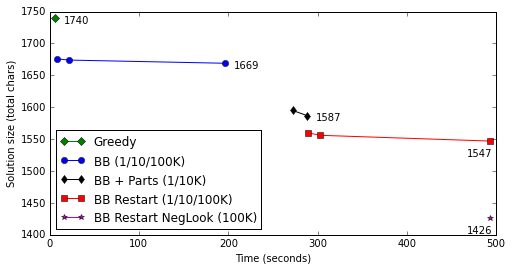

In [62]:
#        Algorithm                   Style  Times            Total character counts
DATA = [('Greedy',                   'gD-', [6],             [1740]),
        ('BB (1/10/100K)',           'bo-', [8, 21, 196],    [1676, 1674, 1669]),
        ('BB + Parts (1/10K)',       'kd-', [272, 288],      [1595, 1587]),
        ('BB Restart (1/10/100K)',   'rs-', [289, 303, 493], [1560, 1556, 1547]),
        ('BB Restart NegLook (100K)','m*-', [493],           [1426])]

def display(data=DATA):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for (label, line, times, counts) in data:
        plt.plot(times, counts, line, label=label)
        x, y = times[-1], counts[-1]
        offset = (-22, -15) if line in ('rs-', 'm*-') else (10, -5)
        ax.annotate(str(y), xy=(x, y), xytext=offset, textcoords='offset points')
    plt.xlabel('Time (seconds)'); plt.ylabel('Solution size (total chars)')
    plt.legend(loc='lower left');

display()

We've made great strides, decreasing the total solution length by 20%.  (It is up to you whether that 20% improvement is worth the increase in time from 6 seconds to 8 minutes.)

# Profiling Again

Now where does the time go? Let's check again:

In [63]:
cProfile.run('findregex(adverbs, nouns)', sort='cumulative')

         59623899 function calls (59278679 primitive calls) in 36.067 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   36.067   36.067 {built-in method builtins.exec}
        1    0.000    0.000   36.067   36.067 <string>:1(<module>)
        1    0.002    0.002   36.067   36.067 <ipython-input-40-69eab5774964>:21(findregex)
        1    0.072    0.072   36.066   36.066 <ipython-input-56-6db5f5ee7e3e>:1(bb_findregex)
100178/10    0.781    0.000   24.877    2.488 <ipython-input-56-6db5f5ee7e3e>:13(search)
   100000    0.593    0.000   20.145    0.000 <ipython-input-31-c9c277f8c298>:1(simplify_covers)
   209152    2.074    0.000   11.561    0.000 <ipython-input-33-2d740317bec1>:1(eliminate_dominated)
        1    0.007    0.007   10.413   10.413 <ipython-input-44-3e740ef01568>:1(regex_covers)
  4047977    2.941    0.000    8.916    0.000 {built-in method builtins.any}
        1    0.104    0.104 

We see that the majority of the time is in `simplify_covers`, and within that, half the time goes to `eliminate_dominated`. That gives us some ideas of where speedups could be made, but gains will be harder now than before.


# Speculating: Other Ideas

I'm going to stop here, but I'll briefly mention some other ideas that I didn't get to investigate.  Perhaps you can play with some of these, or with other ideas.

- *Completely different approach*: [Thomas Breuel](https://plus.google.com/118190679520611168174/posts) suggested doing [minimization](http://en.wikipedia.org/wiki/DFA_minimization) of [weighted finite state transducers](http://nbviewer.ipython.org/url/nlpa.iupr.com/resources/nlpa-openfst.ipynb?attredirects=0&create=1).
- *Character classes*: We never considered character classes, such as `'[abc]'`. It is not obvious they would help, but it is possible.  Consider the fragment `'ld|la'`, which shows up in one of the solutions.  We could replace that with a single component, `'l[da]'`.  But we haven't gained anything; both are 5 characters long.  If we had had `'l.d|l.c|l.b|l.a'` then the replacement `'l.[a-d]'` would save 8 characters, but I don't see many opportunities like that.  It might also be possible to use *negative* character classes, like `l[^y]` to explicitly avoid something in the losers set.

- *Prefilter parts*: Currently, `regex_covers` generates a huge set of components, then eliminates the ones that match losers (or don't match winners), and then eliminates the ones that are dominated.  We could make `regex_covers` faster by not generating components that can't possibly contribute.  Suppose we're considering a subpart, say `'ab'`. If it matches no losers, then there is no reason to extend it to a longer subpart, such as `'abc'`, because we know that `'abc'` is dominated by `'ab'`.  By filtering out dominated parts before we have to check them, I estimate we should be able to cut the time for `regex_covers` in half, maybe better.
- *Better component choice*: We pick the "best" component based on how many winners it covers and how many characters it takes.  Maybe we could have a better measure; perhaps taking into account whether it covers winners that are "easy" to cover by other regexes, or "hard" to cover.
- *Tuning*: We have the two parameters `K` and `F`, which are randomly chosen from a fairly arbitrary distribution.  We could measure which values of the parameters perform better and pick those values more often.
- *Post-editing*: We concentrated on the task of generating a solution from scratch; another task is to improve an existing solution.  For example, take the set of components in a solution, and see if one component could be dropped&mdash;it is possible that all the winners covered by that component might accidentally have been covered by other components, making it unnecessary. Or take all pairs of components, and see if they could be replaced by a shorter set of components.
- *Better bounds*: Branch and Bound search works best if the bounds are tight.  If we can recognize early that the path we are on cannot possibly be as good as the best solution found so far then we can cut off search early and save time.  But the bound estimate we are using now is a poor one.  We estimate the cost of a solution as the cost of the partial solution plus the cost of the shortest component remaining.  We use this estimate because all we know for sure is that we need at least one more component.  Here's one way to get a better bound by recognizing that in many cases we will need more than one more component. We'll define the following quantities:

    + *P* = the length of the partial solution, plus the "|", if needed.  So if the partial solution is `None`, then *P* = 0, else *P* is the length plus 1.
    + *S* = the length of the shortest regex component in `covers`.
    + *W* = the number of winners still in `covers`.
    + *C* = the largest number of winners covered by any regex in `covers`.
    
    The current estimate is *P* + *S*.  We can see that a better estimate is *P* + *S* &times; ceil(*W* / *C*).


I hope you had fun seeing how I (and Stefan) attacked this problem; now go out and solve some problems of your own.



<hr>
[*Peter Norvig*](http://norvig.com),  Feb. 2014